# Load train and validation data

In [1]:
train_lines = []
with open('A1_DATASET/train.txt', 'r') as f:
    train_lines = f.readlines()
train_lines[0]

'I booked two rooms four months in advance at the Talbott . We were placed on the top floor next to the elevators , which are used all night long . When speaking to the front desk , I was told that they were simply honoring my request for an upper floor , which I had requested for a better view . I am looking at a brick wall , and getting no sleep . He also told me that they had received complaints before from guests on the 16th floor , and were aware of the noise problem . Why then did they place us on this floor when the hotel is not totally booked ? A request for an upper floor does not constitute placing someone on the TOP floor and using that request to justify this . If you decide to stay here , request a room on a lower floor and away from the elevator ! I spoke at length when booking my two rooms about my preferences . This is simply poor treatment of a guest whom they believed would not complain .\n'

In [2]:
val_lines = []
with open('A1_DATASET/val.txt', 'r') as f:
    val_lines = f.readlines()
val_lines[0]

"I stayed for four nights while attending a conference . The hotel is in a great spot - easy walk to Michigan Ave shopping or Rush St. , but just off the busy streets . The room I had was spacious , and very well-appointed . The staff was friendly , and the fitness center , while not huge , was well-equipped and clean . I 've stayed at a number of hotels in Chicago , and this one is my favorite . Internet was n't free , but at $ 10 for 24 hours is cheaper than most business hotels , and it worked very well .\n"

# Pre-processing

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\saiki\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
import string

def preprocess(line):
    line = line.lower()
    tokens = nltk.word_tokenize(line)
    tokens = list(filter(lambda x: len(x)!=1 or (len(x)==1 and x not in string.punctuation), tokens))
    tokens = ["<START>"] + tokens + ["<END>"]
    return tokens

In [5]:
preprocess("I have a pen .   I don't have a book, and    ")

['<START>',
 'i',
 'have',
 'a',
 'pen',
 'i',
 'do',
 "n't",
 'have',
 'a',
 'book',
 'and',
 '<END>']

# Unsmoothed Unigrams and Bigrams

In [6]:
from itertools import pairwise

def get_vocab(lines):
    vocab = []
    unigrams = {}
    bigrams = {}
    for line in lines:
        preprocess_line = preprocess(line)
        for token in preprocess_line:
            if token in unigrams.keys():
                unigrams[token] += 1
            else:
                unigrams[token] = 1

        for token, next_token in list(pairwise(preprocess_line)):
            if (token, next_token) in bigrams.keys():
                bigrams[(token, next_token)] += 1
            else:
                bigrams[(token, next_token)] = 1

        vocab.extend(preprocess_line)

    vocab = set(vocab)
    return vocab, unigrams, bigrams

In [7]:
import numpy as np

vocab, unigram_counts, bigram_counts = get_vocab(train_lines)
vocab_len = len(vocab)
total_unigrams = np.sum(list(unigram_counts.values()))
total_bigrams = np.sum(list(bigram_counts.values()))

vocab_len, total_unigrams, total_bigrams

(6309, 81109, 80597)

In [8]:
unigram_probability = {}
for u in unigram_counts.keys():
    unigram_probability[u] = unigram_counts[u]/total_unigrams

In [9]:
bigram_probability = {}
for b in bigram_counts.keys():
    bigram_probability[b] = bigram_counts[b]/unigram_counts[b[0]]

# Unknown word handling

In [10]:
unknown_words = []
for u in unigram_counts.keys():
    if unigram_counts[u] < 2:
        unknown_words += [u]

vocab = vocab - set(unknown_words)
vocab.add("<UNK>")
len(vocab)

3096

In [11]:
from itertools import pairwise

def get_vocab_unknown(lines):
    unigrams = {}
    bigrams = {}
    for line in lines:
        preprocess_line = preprocess(line)
        for token in preprocess_line:
            if token not in vocab:
                token = '<UNK>'
            
            if token in unigrams.keys():
                unigrams[token] += 1
            else:
                unigrams[token] = 1

        for token, next_token in list(pairwise(preprocess_line)):
            if token not in vocab:
                token = '<UNK>'
            if next_token not in vocab:
                next_token = '<UNK>'
                
            if (token, next_token) in bigrams.keys():
                bigrams[(token, next_token)] += 1
            else:
                bigrams[(token, next_token)] = 1

    return unigrams, bigrams

In [12]:
unigram_counts_unk, bigram_counts_unk = get_vocab_unknown(train_lines)
vocab_len = len(vocab)
total_unigrams = np.sum(list(unigram_counts.values()))
total_bigrams = np.sum(list(bigram_counts.values()))

vocab_len, total_unigrams, total_bigrams

(3096, 81109, 80597)

In [13]:
unigram_probability = {}
for u in unigram_counts.keys():
    unigram_probability[u] = unigram_counts[u]/total_unigrams

In [14]:
bigram_probability = {}
for b in bigram_counts.keys():
    bigram_probability[b] = bigram_counts[b]/unigram_counts[b[0]]

# No smoothing

In [15]:
def no_smoothing(uc, bc):
    no_smoothing_unigram = {}
    for uc_item in uc.keys():
        no_smoothing_unigram[uc_item] = (uc[uc_item]) / (total_unigrams)

    no_smoothing_bigram = {}
    for bc_item in bc.keys():
        no_smoothing_bigram[bc_item] = (bc[bc_item]) / (uc[bc_item[0]])

    return no_smoothing_unigram, no_smoothing_bigram

In [16]:
no_smoothing_unigram, no_smoothing_bigram = no_smoothing(unigram_counts_unk, bigram_counts_unk)

# Laplace smoothing

In [17]:
def laplace_smoothing(uc, bc):
    laplace_unigram = {}
    for uc_item in uc.keys():
        laplace_unigram[uc_item] = (uc[uc_item] + 1) / (total_unigrams + vocab_len)

    laplace_bigram = {}
    for bc_item in bc.keys():
        laplace_bigram[bc_item] = (bc[bc_item] + 1) / (uc[bc_item[0]] + vocab_len)

    return laplace_unigram, laplace_bigram

In [18]:
laplace_unigram, laplace_bigram = laplace_smoothing(unigram_counts_unk, bigram_counts_unk)

# k smoothing

In [19]:
def k_smoothing(uc, bc, k):
    k_unigram = {}
    for uc_item in uc.keys():
        k_unigram[uc_item] = (uc[uc_item] + k) / (total_unigrams + k*vocab_len)

    k_bigram = {}
    for bc_item in bc.keys():
        k_bigram[bc_item] = (bc[bc_item] + k) / (uc[bc_item[0]] + k*vocab_len)

    return k_unigram, k_bigram

# Perplexity

In [20]:
def get_val_perplexity_unigram(lines, unigram_model):
    perplexity = 0
    N = 0
    for line in lines:
        preprocess_line = preprocess(line)
        N += len(preprocess_line)
        for token in preprocess_line:
            if token in vocab:
                perplexity += np.log(unigram_model.get(token))
            else:
                perplexity += np.log(unigram_model.get('<UNK>'))
    return np.exp(-perplexity/N)

In [21]:
def get_val_perplexity_bigram(lines, bigram_model):
    perplexity = 0
    N = 0
    for line in lines:
        preprocess_line = preprocess(line)
        N += len(preprocess_line)
        for token, next_token in list(pairwise(preprocess_line)):
            if token not in vocab:
                token = '<UNK>'
            if next_token not in vocab:
                next_token = '<UNK>'
    
            perplexity += np.log(bigram_model.get((token, next_token), bigram_model.get(('<UNK>', '<UNK>'))))
    
    return np.exp(-perplexity/N)

In [22]:
up = get_val_perplexity_unigram(val_lines, no_smoothing_unigram)
print("No smoothing unigram perplexity", up)

No smoothing unigram perplexity 334.04939549283165


In [23]:
bp = get_val_perplexity_bigram(val_lines, no_smoothing_bigram)
print("No smoothing bigram perplexity", bp)

No smoothing bigram perplexity 26.27419728960253


In [24]:
up = get_val_perplexity_unigram(val_lines, laplace_unigram)
print("Laplace unigram perplexity", up)

Laplace unigram perplexity 336.9231410554504


In [25]:
bp = get_val_perplexity_bigram(val_lines, laplace_bigram)
print("Laplace bigram perplexity", bp)

Laplace bigram perplexity 148.16885572941624


In [29]:
k_values = [0.01, 0.05, 0.1, 0.5, 0.75, 1, 1.5, 2, 5]
unigram_perplexities = []
bigram_perplexities = []

for k in k_values:
    k_unigram, k_bigram = k_smoothing(unigram_counts_unk, bigram_counts_unk, k)

    up = get_val_perplexity_unigram(val_lines, k_unigram)
    bp = get_val_perplexity_bigram(val_lines, k_bigram)

    unigram_perplexities.append(up)
    bigram_perplexities.append(bp)

    print("k", k, "unigram perplexity", up, "bigram perplexity", bp)

k 0.01 unigram perplexity 334.0702538117335 bigram perplexity 31.438671310147996
k 0.05 unigram perplexity 334.15570136142924 bigram perplexity 42.14908179696627
k 0.1 unigram perplexity 334.266914692295 bigram perplexity 51.49526979459143
k 0.5 unigram perplexity 335.31117648600747 bigram perplexity 101.21397784081431
k 0.75 unigram perplexity 336.08081799724073 bigram perplexity 125.7687182112564
k 1 unigram perplexity 336.9231410554504 bigram perplexity 148.16885572941624
k 1.5 unigram perplexity 338.7847019583779 bigram perplexity 188.76848656053343
k 2 unigram perplexity 340.8320573388146 bigram perplexity 225.44994311452237
k 5 unigram perplexity 355.2634231662423 bigram perplexity 400.4942288129241


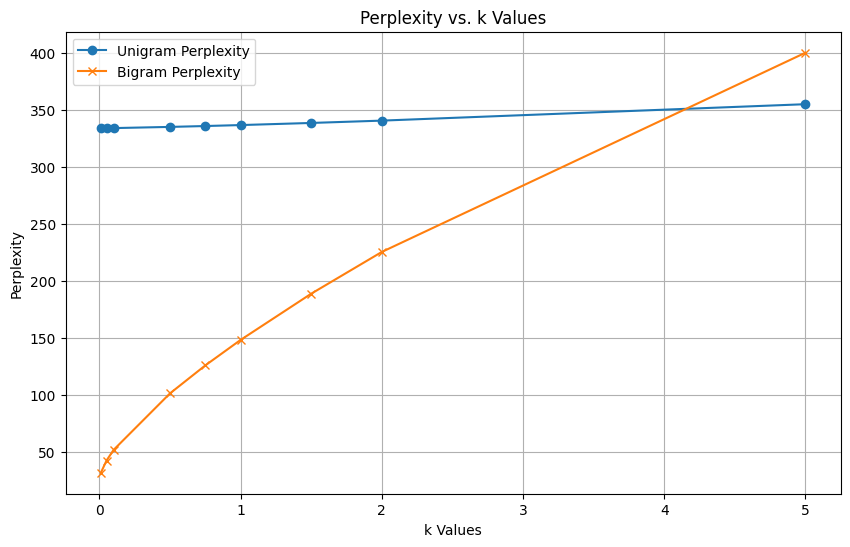

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(k_values, unigram_perplexities, label='Unigram Perplexity', marker='o')
plt.plot(k_values, bigram_perplexities, label='Bigram Perplexity', marker='x')

plt.xlabel('k Values')
plt.ylabel('Perplexity')
plt.title('Perplexity vs. k Values')
plt.legend()

plt.grid(True)
plt.show()